In [1]:
import dask.dataframe as dd
from datetime import datetime
import intake
import numpy as np
import pandas as pd
from tqdm import tqdm

In [2]:
from dask.diagnostics import ProgressBar
pbar = ProgressBar()
pbar.register()

In [3]:
datetime_count = {}

In [4]:
import s3fs

In [5]:
fs = s3fs.S3FileSystem(anon=True)

In [6]:
pqs = []

key = 's3://anaconda-package-data/conda/hourly/'
for base, dirs, files in fs.walk(key):
    for f in files:
        if f.endswith('.parquet'):
            pqs.append(f's3://{base}/{f}')
# list(fs.walk('s3://anaconda-package-data/conda/hourly/'))

In [7]:
len(pqs)
pqs[0], pqs[-1]

('s3://anaconda-package-data/conda/hourly/2017/01/2017-01-01.parquet',
 's3://anaconda-package-data/conda/hourly/2021/09/2021-09-30.parquet')

In [56]:
df = dd.read_parquet(pqs,storage_options={'anon': True})

In [57]:
grouped = df[['data_source', 'time', 'counts']].groupby(by=['data_source', 'time']).sum().compute()

[########################################] | 100% Completed |  2min 37.1s


In [58]:
grouped

counts
data_source time                       
anaconda    2017-01-01 00:00:00    4383
            2017-01-01 01:00:00    4488
            2017-01-01 02:00:00    7107
            2017-01-01 03:00:00    6938
            2017-01-01 04:00:00    5589
...                                 ...
nvidia      2021-09-30 19:00:00     450
            2021-09-30 20:00:00     342
            2021-09-30 21:00:00     149
            2021-09-30 22:00:00     168
            2021-09-30 23:00:00     270

[332648 rows x 1 columns]

In [59]:
grouped

counts
data_source time                       
anaconda    2017-01-01 00:00:00    4383
            2017-01-01 01:00:00    4488
            2017-01-01 02:00:00    7107
            2017-01-01 03:00:00    6938
            2017-01-01 04:00:00    5589
...                                 ...
nvidia      2021-09-30 19:00:00     450
            2021-09-30 20:00:00     342
            2021-09-30 21:00:00     149
            2021-09-30 22:00:00     168
            2021-09-30 23:00:00     270

[332648 rows x 1 columns]

In [60]:
grouped = grouped.reset_index()
grouped.index = grouped['time']
# del grouped['time']
grouped['hour'] = grouped.index.hour

grouped['day'] = grouped.index.day

grouped['month'] = grouped.index.month

grouped['year'] = grouped.index.year


In [61]:
grouped = grouped.reset_index(drop=True)

In [62]:
grouped

,data_source,time,counts,hour,day,month,year
0,anaconda,2017-01-01 00:00:00,4383,0,1,1,2017
1,anaconda,2017-01-01 01:00:00,4488,1,1,1,2017
2,anaconda,2017-01-01 02:00:00,7107,2,1,1,2017
3,anaconda,2017-01-01 03:00:00,6938,3,1,1,2017
4,anaconda,2017-01-01 04:00:00,5589,4,1,1,2017
...,...,...,...,...,...,...,...
332643,nvidia,2021-09-30 19:00:00,450,19,30,9,2021
332644,nvidia,2021-09-30 20:00:00,342,20,30,9,2021
332645,nvidia,2021-09-30 21:00:00,149,21,30,9,2021
332646,nvidia,2021-09-30 22:00:00,168,22,30,9,2021


In [63]:
import matplotlib.pyplot as plt

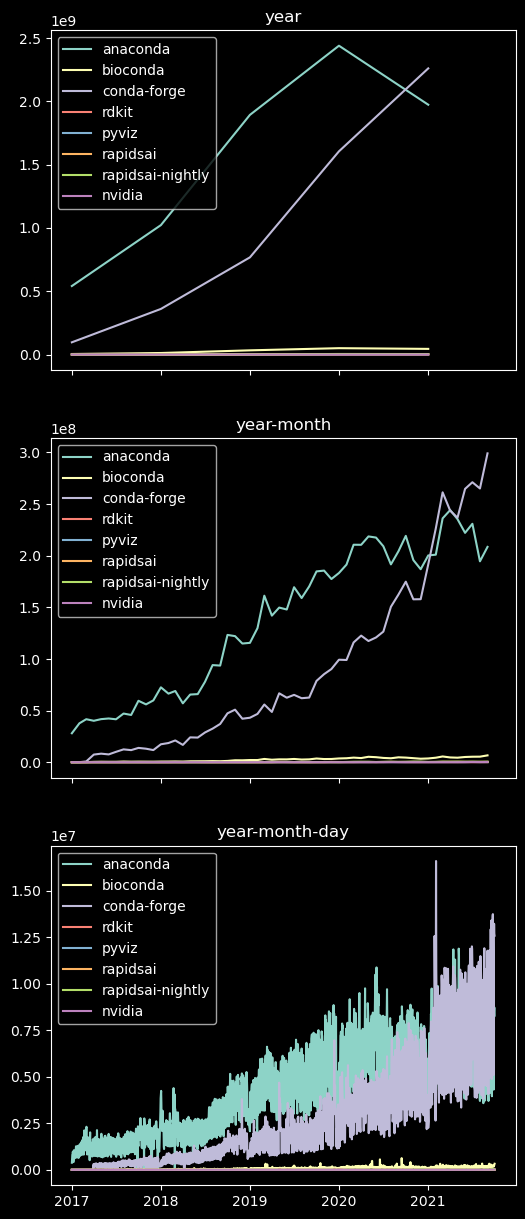

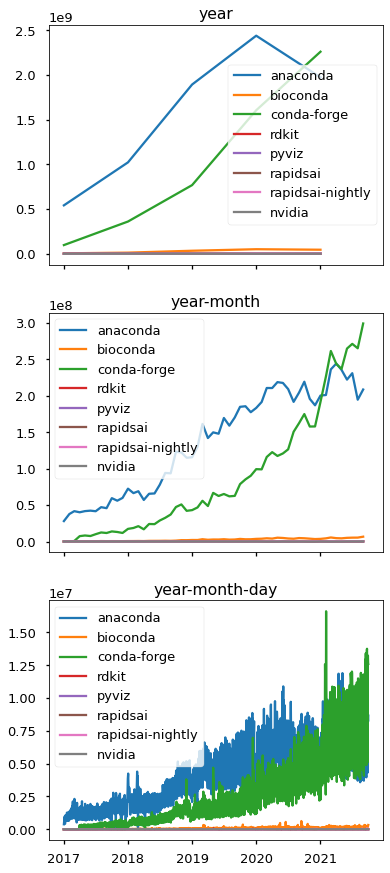

In [64]:
channels = grouped.data_source.unique()
for context in [("dark_background", "seaborn-talk"), ("seaborn-talk", )]:
    with plt.style.context(*context):
        fig, axes = plt.subplots(3, figsize=(6,15), sharex=True);
        groupings = [['year'], ['year', 'month'], ['year', 'month', 'day']]
        for group, ax in zip(groupings, axes):
            for channel in channels:
                df = grouped.loc[grouped.data_source == channel, group + ['counts']].groupby(by=group).agg('sum').reset_index()
                df['dt'] = pd.to_datetime(df.apply(lambda x: '-'.join([f'{x[g]}' for g in group]), axis=1))
                ax.plot('dt', 'counts', '-', data=df, label=channel)
                ax.set_title('-'.join(group))
                ax.relim()
            ax.legend()


In [65]:

df = grouped.loc[grouped.data_source == 'conda-forge', group + ['counts']].groupby(by=group).agg('sum').reset_index()

In [66]:
df

,year,month,day,counts
0,2017,1,1,0
1,2017,1,2,0
2,2017,1,3,0
3,2017,1,4,0
4,2017,1,5,0
...,...,...,...,...
1729,2021,9,26,5097959
1730,2021,9,27,12491458
1731,2021,9,28,13226109
1732,2021,9,29,12690657


In [67]:
all_channels = grouped.data_source.unique()
big_channels = ['conda-forge', 'anaconda']
small_channels = set(all_channels) - set(big_channels)

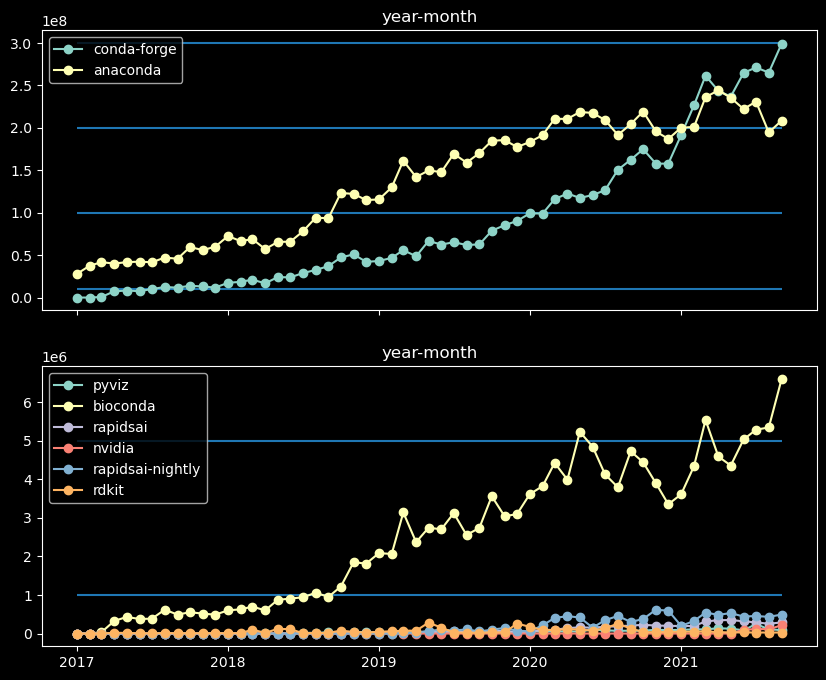

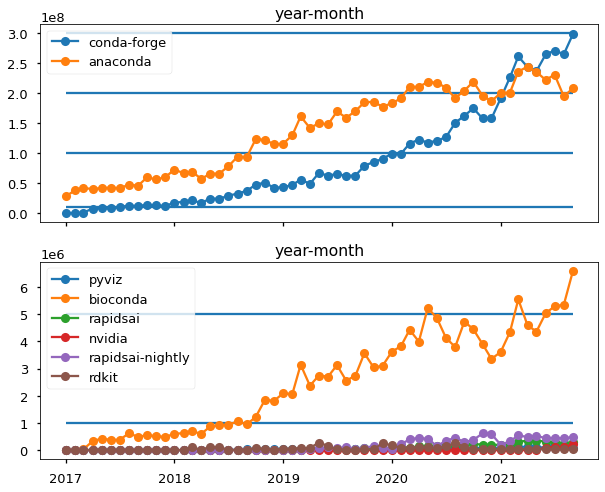

In [68]:

for context in [("dark_background", "seaborn-talk"), ("seaborn-talk", )]:
    with plt.style.context(*context):
        groupings = [['year'], ['year', 'month'], ['year', 'month', 'day']]
        groupings = [['year', 'month']]
        group = groupings[0]
        fig, axes = plt.subplots(2, figsize=(10,8), sharex=True)
        for channels, ax in zip([big_channels, small_channels], axes):
            for channel in channels:
                # df = grouped[group  + ['counts']].groupby(by=group).agg('sum').reset_index()
                df = grouped.loc[grouped.data_source == channel, group + ['counts']].groupby(by=group).agg('sum').reset_index()
                df['dt'] = pd.to_datetime(df.apply(lambda x: '-'.join([f'{x[g]}' for g in group]), axis=1))
                ax.plot('dt', 'counts', '-o', data=df, label=channel)
            ax.set_title('-'.join(group))
            # ax.relim()
            ax.legend()
            
        axes[0].hlines([10e6, 100e6, 200e6, 300e6], xmin=df.dt.min(), xmax=df.dt.max())
        axes[1].hlines([1e6, 5e6], xmin=df.dt.min(), xmax=df.dt.max())


In [69]:
grouped

,data_source,time,counts,hour,day,month,year
0,anaconda,2017-01-01 00:00:00,4383,0,1,1,2017
1,anaconda,2017-01-01 01:00:00,4488,1,1,1,2017
2,anaconda,2017-01-01 02:00:00,7107,2,1,1,2017
3,anaconda,2017-01-01 03:00:00,6938,3,1,1,2017
4,anaconda,2017-01-01 04:00:00,5589,4,1,1,2017
...,...,...,...,...,...,...,...
332643,nvidia,2021-09-30 19:00:00,450,19,30,9,2021
332644,nvidia,2021-09-30 20:00:00,342,20,30,9,2021
332645,nvidia,2021-09-30 21:00:00,149,21,30,9,2021
332646,nvidia,2021-09-30 22:00:00,168,22,30,9,2021


In [70]:
for channel in grouped.data_source.unique():
    total = grouped.loc[grouped.data_source == channel, 'counts'].sum()
    start = grouped.loc[grouped.data_source == channel, 'time'].min()
    print(f'{channel}: {total / 1e6} since {start}')


anaconda: 7869.161263
bioconda: 144.631064
conda-forge: 5089.745378
rdkit: 3.338999
pyviz: 2.62543
rapidsai: 4.926443
rapidsai-nightly: 9.065024
nvidia: 0.5425
